#### <h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Lesson 4:</span> Employee Model Training</h1>
<hr>

At last, it's time to build our models! 

Remember, professional data scientists actually spend the bulk of their time on the 3 steps leading up to this one: 
1. Exploratory Analysis
2. Data Cleaning
3. Feature Engineering

Again, that's because **better data beats fancier algorithms**.

<br><hr id="toc">

### In this lesson...

First, we'll load our analytical base table from Lesson 3. 

Then, we'll go through the essential modeling steps:

1. [Split your dataset](#split)
2. [Build model pipelines](#pipelines)
3. [Declare hyperparameters to tune](#hyperparameters)
4. [Fit and tune models with cross-validation](#fit-tune)
5. [Evaluate metrics](#evaluate)
6. [Area under ROC curve](#auroc)

Finally, we'll save the best model.

<br><hr>

### First, let's import libraries, recruit models, and load the ABT.

First, let's import the libraries that we'll need.

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns 

# Scikit-Learn for Modeling
import sklearn 

# Pickle for saving model files
import pickle 

Next, let's import the algorithms we introduced in the last lesson.

In [2]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Next, let's import the Scikit-Learn functions and helpers we'll need for this lesson.
* Remember, it's OK to just add more imports here as you need them and re-run this cell (it won't change anything else you've done).

In [2]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

Finally, let's read the analytical base table you saved at the end of lesson 3.

In [4]:
# Load analytical base table from lesson 3
df = pd.read_csv('project_files/employee_analytical_base_table.csv')

<span id="split"></span>
# 1. Split your dataset

Just as we did in Lesson 3, let's start by splitting our data into separate training and test sets. 

<br>
**First, separate the dataframe into separate objects for the target variable, <code style="color:steelblue">y</code>, and the input features, <code style="color:steelblue">X</code>.**

In [5]:
# Create separate object for target variable
y = df.status

# Create separate object for input features
X = df.drop('status', axis=1)

**After you've imported the <code style="color:steelblue">train_test_split()</code> function, split <code style="color:steelblue">X</code> and <code style="color:steelblue">y</code> into training and test sets.**
* Pass in the argument <code style="color:steelblue">test_size=<span style="color:crimson">0.2</span></code> to set aside 20% of our observations for the test set.
* Pass in <code style="color:steelblue">random_state=<span style="color:crimson">1234</span></code> to set the random state for replicable results.
* **Important:** Also pass in the argument <code style="color:steelblue">stratify=<span style="color:crimson">df.status</span></code> in order to make sure the target variable's classes are balanced in each subset of data! This is **stratified random sampling**.
* Then, print the number of observations in each subset to check that it was done correctly.

In [6]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print (len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="pipelines"></span>
# 2. Build model pipelines

Next, let's set up preprocessing pipelines for each of our algorithms.

<br>
**Create a single <span style="color:royalblue">pipeline dictionary</span> with pipelines for each algorithm**.
* Use the keys:
    * <code style="color:crimson">'l1'</code> for $L_1$-regularized logistic regression
    * <code style="color:crimson">'l2'</code> for $L_2$-regularized logistic regression
    * <code style="color:crimson">'rf'</code> for random forest
    * <code style="color:crimson">'gb'</code> for gradient boosted tree.
* Each pipeline should standardize the data first.
* Remember to set <code style="color:steelblue">random_state=<span style="color:crimson">123</span></code> for each algorithm to ensure replicable results.

In [7]:
# Pipeline dictionary
pipeline_dict = {'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)), 
                                     'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
                                     'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
                                     'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
                }

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="hyperparameters"></span>
# 3. Declare hyperparameters to tune

Next, let's declare hyperparameters to tune.

<br>
**First, list the tunable hyperparameters of your $L_1$-regularized logistic regression pipeline.**

In [8]:
# List tuneable hyperparameters of our Logistic pipeline
pipeline_dict['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logis

Let's declare the **hyperparameter grids** to tune.

In [9]:
# Logistic Regression hyperparameters
l1_hyperparameters = { 'logisticregression__C': np.linspace(1e-3, 1e3, 10)}
l2_hyperparameters = { 'logisticregression__C': np.linspace(1e-3, 1e3, 10)}

**Declare the hyperparameter grid for the random forest.**

In [10]:
# Random Forest hyperparameters
rf_hyperparameters = { 'randomforestclassifier__n_estimators': [100, 200],
                         'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]}

**Declare the hyperparameter grid for the boosted tree.**

In [11]:
# Boosted Tree hyperparameters
gb_hyperparameters = {'gradientboostingclassifier__n_estimators': [100, 200], 
                    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2], 
                     'gradientboostingclassifier__max_depth': [1, 3, 5]}

**Create a <code style="color:steelblue">hyperparameters</code> dictionary**.
* Use the same keys as in the <code style="color:steelblue">pipelines</code> dictionary.

In [12]:
# Create hyperparameters dictionary
hp_dict = { 'l1': l1_hyperparameters, 'l2': l2_hyperparameters, 'rf': rf_hyperparameters, 'gb': gb_hyperparameters}

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="fit-tune"></span>
# 4. Fit and tune models with cross-validation

Now that we have our <code style="color:steelblue">pipelines</code> and <code style="color:steelblue">hyperparameters</code> dictionaries declared, we're ready to tune our models with **cross-validation**.

<br>
**Create a <code style="color:SteelBlue">fitted_models</code> dictionary that includes models that have been tuned using cross-validation.**
* The keys should be the same as those in the <code style="color:SteelBlue">pipelines</code> and <code style="color:SteelBlue">hyperparameters</code> dictionaries. 
* The values should be <code style="color:steelblue">GridSearchCV</code> objects that have been fitted to <code style="color:steelblue">X_train</code> and <code style="color:steelblue">y_train</code>.
* After fitting each model, print <code style="color:crimson">'{name} has been fitted.'</code> just to track the progress.
* (Optionally) You can set <code style="color:steelblue">n_jobs=<span style="color:crimson">-1</span></code> to use as many cores as available on your computer.

This step can take a few minutes, so please be patient.

In [13]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipeline_dict.items(): 
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hp_dict[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted')

l1 has been fitted
l2 has been fitted
rf has been fitted
gb has been fitted


<span id="evaluate"></span>
# 5. Evaluate metrics

Finally, it's time to evaluate our models and pick the best one.

<br>
**First, display the <code style="color:steelblue">best\_score_</code> attribute for each fitted model.**

In [14]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.8493868846632309
l2 0.8493868846632309
rf 0.9794739648125111
gb 0.9752976719388662


If you get different numbers, check to see that you've set the <code style="color:steelblue">random_state=</code> correctly for each of the models.

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="auroc"></span>
# 6. Area under ROC curve

**Area under ROC curve** is the most reliable metric for classification tasks.

<br>
**Add this import to the top of your Companion Workbook (good practice for keeping all your imports in one place.** 
* Remember to run the entire code cell afterward.

In [15]:
# Classification metrics
from sklearn.metrics import roc_curve, auc

Before presenting the idea of an ROC curve, we must first discuss what a **confusion matrix** is. 

Let's see an example using our $L_1$-regularized logistic regression. 
* First, let's use <code style="color:steelblue">.predict()</code> to get the predicted classes directly.

In [16]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['l1'].predict(X_test)

# Display first 10 predictions
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

* Next, let's display the confusion matrix:

In [17]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print (confusion_matrix(y_test, pred))

[[1969  172]
 [ 221  452]]


Remember, we can predict a **probability** for each class using <code style="color:steelblue">.predict_proba()</code>, instead of the class directly.

For example:

In [18]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l1'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
pred[:10]

[0.0305706280024719,
 0.004443189312389667,
 0.007296724678182576,
 0.08809201014692791,
 0.07114924543317018,
 0.48162744027968424,
 0.1260440848219425,
 0.6152946654110337,
 0.7266446121367226,
 0.13704471581272193]

Let's calculate the ROC curve using the <code style="color:steelblue">roc_curve()</code> function that we imported earlier.

In [19]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

We can throw these into a DataFrame for convenience and look at the last 10:

In [20]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds}).tail(10)

,FPR,TPR,Thresholds
534,0.759925,0.994056,0.009628
535,0.784680,0.994056,0.008121
536,0.784680,0.995542,0.008077
537,0.910322,0.995542,0.001963
538,0.910322,0.997028,0.001951
539,0.932742,0.997028,0.001394
540,0.932742,0.998514,0.001388
541,0.949089,0.998514,0.001051
542,0.949089,1.000000,0.001040
543,1.000000,1.000000,0.000027


As you can see, as you decrease the threshold, both the false positive rate **and** the true positive rate increase.

We can plot the entire curve.

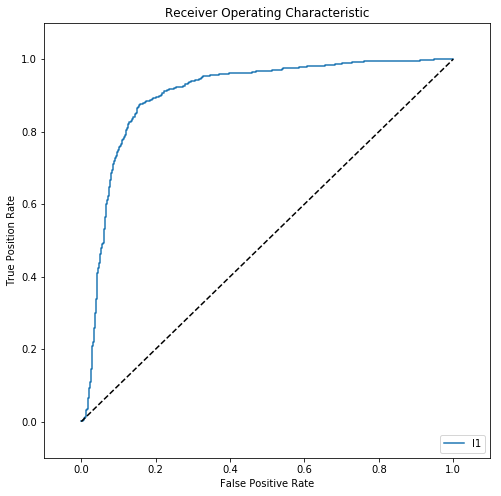

In [21]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1], 'k--')

# Axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Position Rate')
plt.xlabel('False Positive Rate')
plt.show()


To calculate AUROC, use the <code style="color:steelblue">auc()</code> function we imported earlier in conjunction with the <code style="color:steelblue">roc_curve()</code> function.

In [22]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# Calculate AUROC
print(auc(fpr, tpr))

0.9015388373737676


Now that we've taken a detour to dive into some of the intuition behind AUROC, let's calculate it for each of our fitted models on the test set.

<br>
**Using a <code style="color:SteelBlue">for</code> loop, print the performance of each model in <code style="color:SteelBlue">fitted_models</code> on the test set.**
* Print the <code style="color:SteelBlue">auc</code> of the <code style="color:SteelBlue">roc_curve</code>.
* Label the output with the name of the algorithm. For example:

<pre style="color:crimson">
rf 0.991520189216
</pre>

In [23]:
# Code here
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(name, auc(fpr, tpr))

l1 0.9015388373737676
l2 0.9015388373737674
rf 0.9911901855307785
gb 0.9893260637673998


**Finally, save the winning <code style="color:steelblue">Pipeline</code> object into a pickle file.**
* Just save the <code style="color:steelblue">Pipeline</code>, not the <code style="color:steelblue">GridSearchCV</code> object.
* **Hint:** Remember the <code style="color:steelblue">.best\_estimator_</code> attribute?

In [24]:
# Save winning model as final_model.pkl
# with open('saved_models/employee_final_model.pkl', 'wb') as f:
#     pickle.dump(fitted_models['rf'].best_estimator_, f)

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<br>
## Next Steps

Congratulations for making through Lesson 4's Model Training lesson!

As a reminder, here are a few things you did in this lesson:
* You split your dataset into training and test sets.
* You set up model pipelines and hyperparameter grids.
* You tuned your models using cross-validation.
* You learned about how AUROC is a more effective metric for classification than simple accuracy.
* And finally, you saved the winning model.

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>